# This script uses the starting points of the weather sonde trajectories to pinpoint the instantaneous profiles associated with each trajectory starting point

 ## Preliminary Steps

In [1]:
#Import Packages
import xarray as xr
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import metpy 
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units 
from IPython.display import HTML, display 
import imageio
from tqdm import tqdm
from itertools import product 
import wrf
import glob 
from scipy.interpolate import RegularGridInterpolator, interp1d
from mpl_toolkits.mplot3d import Axes3D

Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [6]:
#Create Path For Data Collection and Create A List of File Names
storm16_data_path = '/storage/work/bsh5393/storm16/'
storm16_files = os.listdir(storm16_data_path)

#Remove Unneccessary Files From Storm 16 File List
storm16_files.remove('README-TIMELEVELS')
storm16_files.remove('namelist.input')
storm16_files.remove('runstorm16.pbs.o44255112')
storm16_files.remove('cm1out_stats.nc')

#Step 1: Initialization and Input Parameters

#Data at t = 2hrs
storm_data = xr.open_dataset(storm16_data_path + storm16_files[-1])

#Dataset Domain Size
ni = storm_data['ni']
nj = storm_data['nj']
nk = storm_data['nk']

#Datapoint Locations
x_data = storm_data['xh']*units.kilometer
y_data = storm_data['yh']*units.kilometer
z_data = storm_data['z']*units.kilometer

#Grid Locations (n+1)
x_grid = storm_data['xf']*units.kilometer
y_grid = storm_data['yf']*units.kilometer
z_grid = storm_data['zf']*units.kilometer

#Create New Lower/Upper Bound Variables Since We are not in the center of the domain anymore
lower_bound_x = np.abs(x_data.values - (x_data.max().values-25)).argmin()-2
upper_bound_x = np.abs(x_data.values - (x_data.max().values)).argmin()
lower_bound_y = np.abs(y_data.values + 25).argmin()
upper_bound_y = np.abs(y_data.values).argmin()+2
horiz_length = upper_bound_y-lower_bound_y

#Grid Size 
size_x = size_y = upper_bound_x-lower_bound_x
size_z = len(z_data)

#Grid Spacing 
dx = x_data[1].values - x_data[0].values
dy = y_data[1].values - y_data[0].values
dz = np.zeros(len(z_data))
dz[0] = z_data[0].values
dz[1:] = z_data[1:].values-z_data[0:-1].values

#Time Intervals of Data
time = []
for x in np.arange(1,len(storm16_files),1):
    t = xr.open_dataset(storm16_data_path + storm16_files[x])['time']
    time.append(t)    
time = (np.asarray(time)*10**-9).reshape(len(time))
time = time.astype('int')
time = time - time[0]+30 #time elapsed in seconds (useful for interpolation later on)

#Time Intervals of Interpolation (We want every 10 seconds)
int_time = np.arange(int(time[0]), int(time[-1]), 10)
nanal = len(int_time) #Number of Trajectory Points 
dt = int_time[1]-int_time[0]

#Input Parameters 
asc_rate = 5 #3 m/s ascent rate of balloon

In [4]:
#Compute Temperature from pressure and potential temperature using adiabatic relationship
def comp_T_from_Th(pressure, pot_temperature):
    P_0 = 100000
    R_d = 287 #J/(kg*K)
    c_p = 1004 #J/(kg*K)
    K = R_d/c_p
    T = pot_temperature*(P_0/pressure)**(-K)
    
    return T;

In [5]:
#Compute Dewpoint Temperature from pressure, temperature, and specific humidity
def comp_dewpoint(pressure, temperature, specific_humidity):
    
    q = specific_humidity
    eps = 0.622
    
    #mixing ratio
    w = q/(1-q)
    
    #vapor pressure (in Pa converted to mb)
    e = 0.01*(pressure*w)/(eps+w)
    
    #Dewpoint from Bolton 1980
    T = (243.5*np.log(e/6.112))/(17.67-np.log(e/6.112))+273.15
    
    return T;
    
    

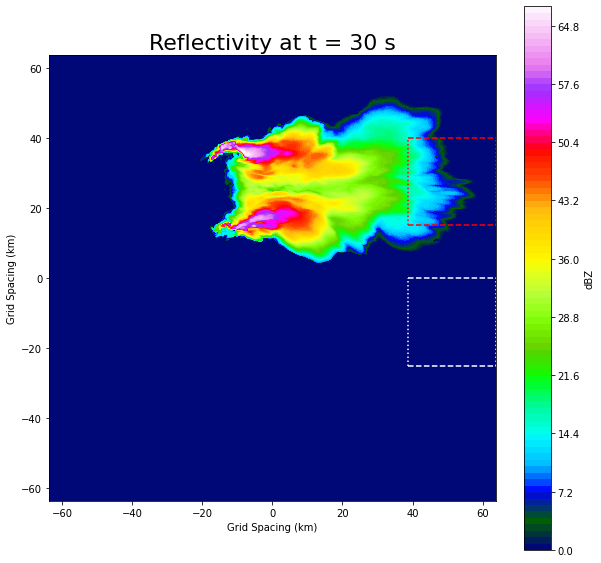

In [7]:
#Create Image For Box Visualization

#Storm 16
dbz_storm16 = []
#thpert_storm16 = []

for x in range(len(storm16_files)):
    t = xr.open_dataset(storm16_data_path + storm16_files[x])['dbz']
    #m = xr.open_dataset(storm16_data_path + storm16_files[x])['thpert']
    dbz_storm16.append(t)
    #thpert_storm16.append(m)
    
#Create A Rough Image
#Fix Aspect Ratio
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

refl = plt.contourf(x_data,y_data,dbz_storm16[1][0].isel(nk = 20), levels=100, cmap ='gist_ncar')
#pert = plt.contour(x_data,y_data, thpert_storm16[1][0][0]-Mean_th, levels = [-0.2], colors ='w')
#ncar color bar = gist_ncar
#Set Box Bounds
lower_bound_x, upper_bound_x = x_data[lower_bound_x],x_data[upper_bound_x]
lower_bound_y, upper_bound_y = y_data[lower_bound_y], y_data[upper_bound_y]

#Plot Box of Domain of Interest
#Plot horizontal lines for the top and bottom of the box
ax.plot([lower_bound_x, upper_bound_x], [lower_bound_y, lower_bound_y], color='w', linestyle='--')
ax.plot([lower_bound_x, upper_bound_x], [upper_bound_y, upper_bound_y], color='w', linestyle='--')

# Plot vertical lines for the left and right of the box
ax.plot([lower_bound_x, lower_bound_x], [lower_bound_y, upper_bound_y], color='w', linestyle=':')
ax.plot([upper_bound_x, upper_bound_x], [lower_bound_y, upper_bound_y], color='w', linestyle=':')

# Plot Original Box
ax.plot([x_data.max().values-25, x_data.max().values], [15, 15], color='r', linestyle='--')
ax.plot([x_data.max().values-25, x_data.max().values], [40, 40], color='r', linestyle='--')
ax.plot([x_data.max().values-25, x_data.max().values-25], [15, 40], color='r', linestyle=':')
ax.plot([x_data.max().values, x_data.max().values], [15, 40], color='r', linestyle=':')

plt.title(f"Reflectivity at t = 30 s", fontsize=22)
plt.colorbar(refl, label = 'dBZ')
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
ax.set_aspect('equal')

## The Good Stuff

In [11]:
#Points From Trajectories
path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

traj_points = np.load(path+'interpolation_2_rawtrajectories.npz')['interp_points']


In [12]:
#We need to find the index nearest for each trajectory starting point to pinpoint the instaneous profile

#Grid Values
x = x_data.values
y = y_data.values
z = z_data.values


#Format of nearest index: sz,sy,sx
#Create Index Storage
inst_ind = np.zeros((traj_points[0].shape), dtype = int)

#Create A Loop That Finds Nearest Index For Every Starting Point
for i in tqdm(np.arange(0, (traj_points[0]).shape[0],1)):
    # separate the x, y, z coordinates
    xp = traj_points[0][i,2]
    yp = traj_points[0][i,1]
    zp = traj_points[0][i,0]
    
    # grabs the closest CM1 gridpoint
    sx = np.searchsorted(x, xp)
    sy = np.searchsorted(y, yp)
    sz = np.searchsorted(z, zp) - 1
    
    # recombine
    inst_ind[i] = sz,sy,sx
    

# Max and Min Of Each Index Range
z_min = inst_ind[:,0].min()
z_max = inst_ind[:,0].max()
y_min = inst_ind[:,1].min()
y_max = inst_ind[:,1].max()
x_min = inst_ind[:,2].min()
x_max = inst_ind[:,2].max()

# Shift Inst_Ind Array (this is needed because in the following cell, once the slice function 
# is used to grab a subset of the netCDF, it reorders all the indices such that the lowest x and y index is 
# now 0, which means we now need to shift our indices downward as well, so we're grabbing the right profile 
# for the right starting point)  
inst_ind[:,0] = inst_ind[:,0] - z_min
inst_ind[:,1] = inst_ind[:,1] - y_min
inst_ind[:,2] = inst_ind[:,2] - x_min

100%|██████████| 112225/112225 [00:01<00:00, 88862.93it/s]


In [13]:
#Instantaneous Data From Model Output (t = 30s : start of weather sonde lifting)
#Trim the Data We Are Bringing in Based on index range to cut down computation time
inst_storm_data = xr.open_dataset(storm16_data_path + storm16_files[1])[['prs','th','qv','uinterp','vinterp','winterp','zvort']].isel(time=0, nj=slice(y_min, y_max+1), ni=slice(x_min, x_max+1))

#Decomposing Preemptively into arrays to save additional time
P_data = inst_storm_data['prs'].values
Th_data = inst_storm_data['th'].values
qv_data = inst_storm_data['qv'].values
u_data = inst_storm_data['uinterp'].values
v_data = inst_storm_data['vinterp'].values
w_data = inst_storm_data['winterp'].values
zvort_data = inst_storm_data['zvort'].values


In [14]:
#Create A Loop That Saves Instantaneous Vertical Data For Each Starting Trajectory Point
#Essentially just reshaping the DataArray where the orginal data is

#Create Storage Arrays
P = np.zeros((121,112225))
Th = np.zeros((121,112225))
qv = np.zeros((121,112225))
u = np.zeros((121,112225))
v = np.zeros((121,112225))
w = np.zeros((121,112225))
zvort = np.zeros((121,112225))

for i in tqdm(np.arange(0,traj_points.shape[1],1)):
    #Decompose Indices Array
    sy = inst_ind[i,1]
    sx = inst_ind[i,2]
    
    #Grab Appropriate Vertical Column
    P[:,i] = P_data[:,sy,sx]
    Th[:,i] = Th_data[:,sy,sx]
    qv[:,i] = qv_data[:,sy,sx]
    u[:,i] = u_data[:,sy,sx]
    v[:,i] = v_data[:,sy,sx]
    w[:,i] = w_data[:,sy,sx]
    zvort[:,i] = zvort_data[:,sy,sx]

100%|██████████| 112225/112225 [00:01<00:00, 73039.53it/s]


In [15]:
#Now Let's Work on Doing Calculations To Create Soundings (Only Run Once)

#Create New Variables

T = np.zeros(P.shape)
Td = np.zeros(P.shape)

#I personally don't like metpy for the calculations. I'm going to create two functions that do metpy things better.
for i in tqdm(np.arange(0,P.shape[1],1)):
    T[:,i] = comp_T_from_Th(P[:,i], Th[:,i])
    Td[:,i] = comp_dewpoint(P[:,i], T[:,i], qv[:,i])
    

100%|██████████| 112225/112225 [00:02<00:00, 38302.55it/s]


In [16]:
#Compute Parcel Profile
parcel_prof = np.zeros(P.shape)

for i in tqdm(np.arange(0,P.shape[1], 1)):
    parcel_prof[:,i] = (metpy.calc.parcel_profile(P[:,i]*units.Pa, (T[:,i]*units.kelvin)[0], (Td[:,i]*units.kelvin)[0])).magnitude


100%|██████████| 112225/112225 [2:20:59<00:00, 13.27it/s] 


In [17]:
#Save The Data Calculated So Far (Need to do CAPE,CIN,SRH1km, SRH3km)

path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

np.savez(path+'instantaneous_data', P = P, T = T, Td = Td, Th = Th, qv = qv, u = u , v = v, w = w, zvort = zvort, parc_T = parcel_prof)

In [18]:
#Check Data in .npz file
path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'
x = np.load(path+'instantaneous_data.npz')
for k in x.iterkeys():
    print(k)

P
T
Td
Th
qv
u
v
w
zvort
parc_T


/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: NpzFile.iterkeys is deprecated in python 3, to match the removal of dict.iterkeys. Use .keys() instead.
  after removing the cwd from sys.path.


In [19]:
#Read in Saved Data 
path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

data = np.load(path+'instantaneous_data.npz')

P = data['P']
T = data['T']
Td = data['Td']
Th = data['Th']
qv = data['qv']
u = data['u']
v = data['v']
w = data['w']
zvort = data['zvort']
parc_T = data['parc_T']

In [20]:
#Calculate CAPE, CIN, SRH1km, SRH3km

CAPE = np.zeros(P.shape)
CIN = np.zeros(P.shape)
SRH1km = np.zeros(P.shape[1])
SRH3km = np.zeros(P.shape[1])

for n in tqdm(np.arange(0,P.shape[1], 1)):
    #For the WRF CAPE Function We Need: Total Pressure (hPa), Temperature (degK), Water Vapor Mixing Ratio (kg/kg), *Geopotential Height* (m), Terrain Height (m), Surface Pressure (hPa)
    results = wrf.cape_3d(P[:,n]/100, T[:,n], qv[:,n], z_data.values*1000, 0,P[0,n]/100,ter_follow = False,meta= False)
    CAPE[:,n] = results[0][:,0,0]
    CIN[:,n] = results[1][:,0,0]
    SRH1km[n] = (mpcalc.storm_relative_helicity(z_data.values*units.km, u[:,n]*units('m/s'), v[:,n]*units('m/s'), depth = 1000*units('m')))[0].magnitude
    SRH3km[n] = (mpcalc.storm_relative_helicity(z_data.values*units.km, u[:,n]*units('m/s'), v[:,n]*units('m/s'), depth = 3000*units('m')))[0].magnitude

100%|██████████| 112225/112225 [22:04<00:00, 84.71it/s]


In [21]:
#Save The Data Calculated So Far (Need to do CAPE,CIN,SRH1km, SRH3km)

path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

np.savez(path+'instantaneous_data', interp_points = traj_points, P = P, T = T, Td = Td, Th = Th, qv = qv, u = u , v = v, w = w, zvort = zvort, parc_T = parc_T, CAPE = CAPE, CIN = CIN, SRH1km = SRH1km, SRH3km = SRH3km)
